In [1]:
# Import for CNN project
from __future__ import print_function, division

import sys 
import os
import time
import copy
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets,transforms,datasets,models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#rename the folder to replace space by _
def read_folder(path):
    file=os.listdir(path)
    for name in file:
        if name.find(' ') != -1:
            os.rename(path+'/'+ name, path +'/'+name.replace(' ','_'))

In [3]:
path_train = 'fruits-360/Training'
path_test = 'fruits-360/Test'

#Call the function to rename sub-folders
read_folder(path_train)
read_folder(path_test)

In [4]:
# create datasets
def initDatasets(batch_size):
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
        
    train_dataset = datasets.ImageFolder(path_train, transform= train_transform)
    train_loader = DataLoader(train_dataset, batch_size= batch_size , shuffle=True)

    test_dataset = datasets.ImageFolder(path_test, transform= test_transform)
    test_loader = DataLoader(test_dataset, batch_size= batch_size , shuffle=True)
    
    return train_dataset,train_loader,test_dataset,test_loader

In [5]:
# Init default dataset (batch_size = 8)
train_dataset,train_loader,test_dataset,test_loader = initDatasets(8)

In [6]:
class ConvNet(nn.Module):
    '''''
    Define the layers in the network
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6) # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift 
        self.drop1 = nn.Dropout2d(0.05) # Randomly zero out entire channels 
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout2d(0.05)
        

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 22 * 22, 120) # (size of input, size of output)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 83)
    '''''
    Implement the forward computation of the network
    '''
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#check GPU on machine
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

convNet = ConvNet().to(device)
print(convNet)

cpu
ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout2d(p=0.05)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=7744, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=83, bias=True)
)


In [7]:
# choose the loss function and update rule
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(convNet.parameters(), lr=0.001)

In [8]:
def train(epochs=5):
    since = time.time()
    print("Begin training")
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
            #get the input
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            #clear the parameter gradients
            optimizer.zero_grad()
            
            #train 
            outputs = convNet(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i%2000 == 1999:
                print('[%d, %5d] loss : %.3f' %(epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
train()

Begin training
Epoch 0/4
----------
[1,  2000] loss : 4.394
[1,  4000] loss : 2.881
Epoch 1/4
----------
[2,  2000] loss : 0.511
[2,  4000] loss : 0.271
Epoch 2/4
----------
[3,  2000] loss : 0.126
[3,  4000] loss : 0.096
Epoch 3/4
----------
[4,  2000] loss : 0.063
[4,  4000] loss : 0.053
Epoch 4/4
----------
[5,  2000] loss : 0.024
[5,  4000] loss : 0.031
Training complete in 14m 49s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([78, 16,  3, 24, 29, 69, 31, 20])


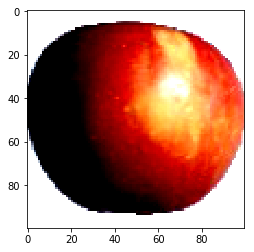

In [9]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

# show images
images,labels = train_loader.dataset[0]
imshow(torchvision.utils.make_grid(images))

# Test 
testiter = iter(test_loader)
images, labels = testiter.next()
print(labels)

In [10]:
outputs = convNet(images)
_,predicted = torch.max(outputs,1)
print(predicted)

tensor([78, 16,  3, 24, 29, 69, 31, 19])


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images,labels = data
        outputs = convNet(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000 test images : %d %% " %(100 * correct/total))

Accuracy of the network on the 10000 test images : 93 % 


In [12]:
# test overfitting 
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images,labels = data
        outputs = convNet(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the training images : %d %% " %(100 * correct/total))

Accuracy of the network on the training images : 99 % 


# Overfitting on training datasets